# PyTorch Workflow
1. Preparing and loading data,
2. Building a model,
3. Fitting the model to data (training),
4. Making predictions and evaluating the model (inference),
5. Saving and loading the model

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.1.0+cu121'

In [49]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 1. Data
We'll use a linear regression formula to make a straight line with known parameters.

In [28]:
# Create parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, there will be errors
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets

In [29]:
train_split = int(0.8 * len(X))
train_split

40

In [30]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [31]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14});

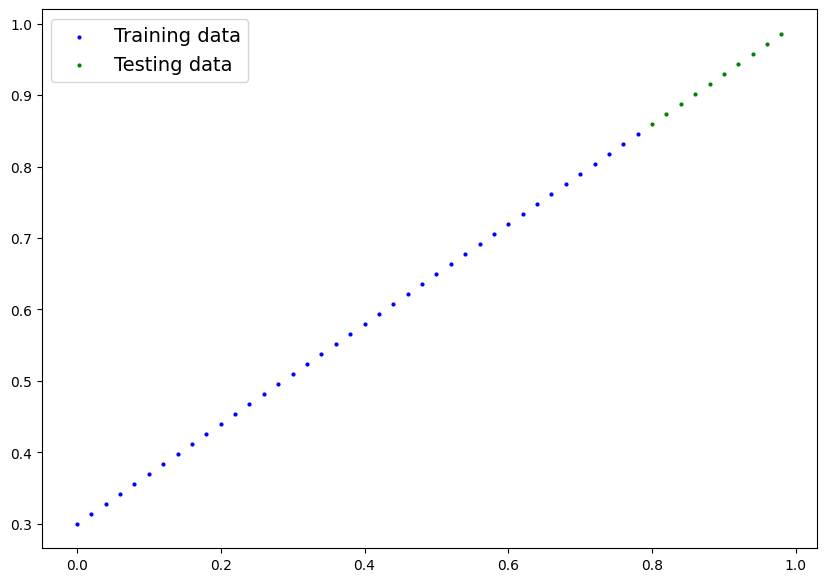

In [7]:
plot_predictions()

## 2. Build model
* Start with random values (weight and bias),
* Look at training data and adjust the random values to better represent or get closer to the ideal values (the weight and bias values that were used to create the data).

The model does this through two main algorithms:
* Gradient descent,
* Backpropagation.

In [32]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias

### PyTorch model building essentials
* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered as a computational graph).
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us.
* `torch.nn.Module` - the base class for all neural network modules, if you subclass it, you should overwrite `forward()`.
* `torch.optim` - PyTorch optimizers which will help with gradient descent.
* `def forward()` - all `nn.Module` subclasses require you to overwrite `forward()`, this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

In [33]:
torch.manual_seed(42)

# Create an instance of the model - a subclass of nn.Module
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [8]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

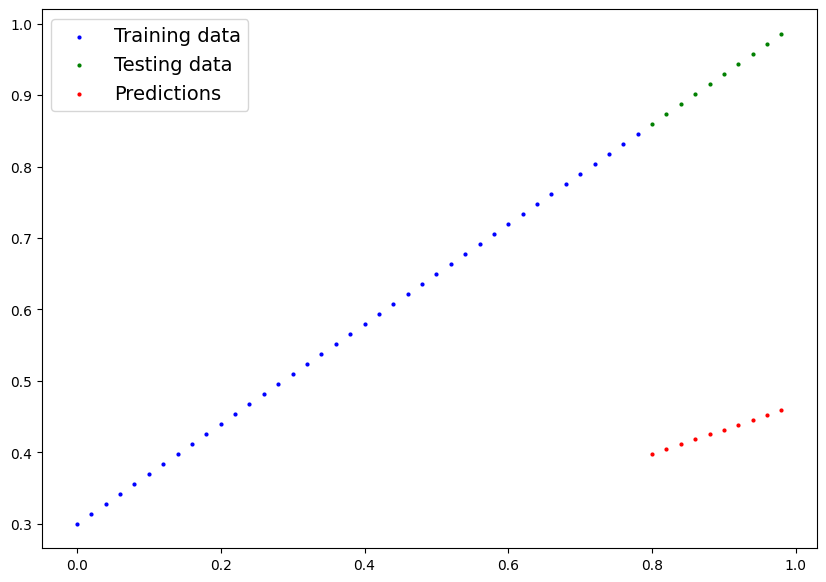

In [13]:
plot_predictions(predictions=y_preds)

In [14]:
# with torch.no_grad():
#   y_preds = model_0(X_test)

## 3. Train model

One way to measure how poor or wrong the model's predictions are is to use a loss function (cost/criterion function).

We also need an optimizer which takes into account the loss of the model and adjust parameters to improve the loss function.

Specifically for PyTorch, we need a training loop and a testing loop.

In [34]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr - learning rate, very important (the smaller the lr is, the smaller are changes in parameters)

### Building training and testing loops in PyTorch
Training loop:
* Loop through the data,
* Forward pass (this involves data moving through model's `forward()` function) to make predictions on data, also called forward propagation,
* Calculate the loss - compare forward pass predictions to ground truth labels,
* Optimizer zero grad,
* Loss backward (backpropagation) - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss,
* Optimizer step (gradient descent) - use the optimizer to adjust the model's parameters to try and improve the loss.

In [35]:
# An epoch - one loop through the data (this is a hyperparameter because we've set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# Training
# Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # sets all parameters that require gradients

  # Forward pass
  y_pred = model_0(X_train)

  # Calculate the loss (MAE)
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Gradient descent
  optimizer.step() # by default how the optimizer changes will accumulate through the loop so we have to zero it above with optimizer.zero_grad()

  # Testing
  model_0.eval() # turns off settings not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking
    # Forward pass
    test_pred = model_0(X_test)

    # Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())
    print("========================================================")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [36]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

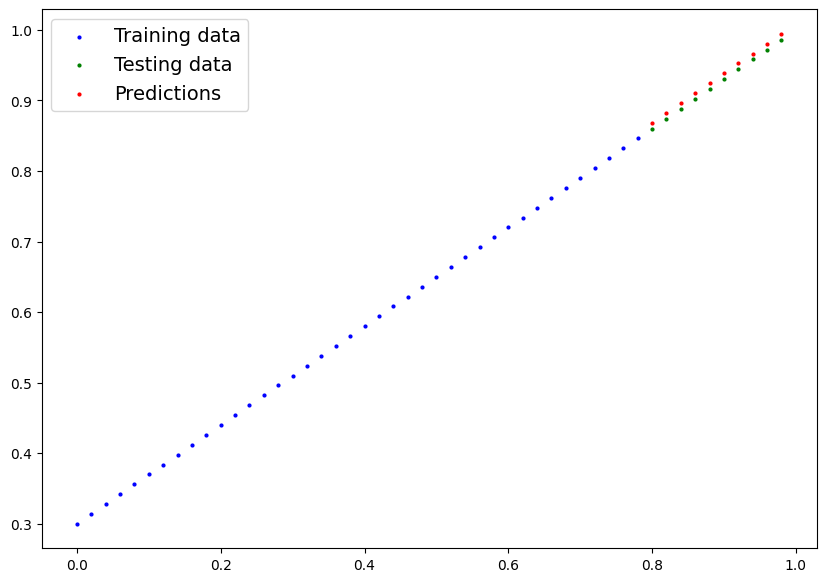

In [37]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

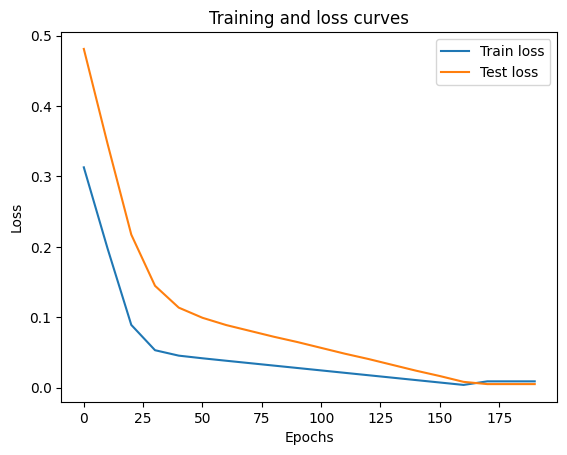

In [38]:
# Plot the loss curve
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving and loading a model
* `torch.save()` - save a PyTorch object in Python's pickle format,
* `torch.load()`,
* `torch.nn.Module.load_state_dict()` - load a model's saved state dictionary.

In [40]:
from pathlib import Path

# Create model's directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model's save path
MODEL_NAME = "pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model_0.pth


In [41]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1662 Jan 28 22:55 pytorch_workflow_model_0.pth


We saved state dictionary rather than entire model, so we need to create a new instance of our model and load the saved state dictionary into it.

In [42]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [44]:
loaded_model_0.state_dict() == model_0.state_dict()

True

In [45]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [47]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [48]:
# Compare loaded model preds with original preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [51]:
# Create simplified version of previous model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [52]:
# Check the model's current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# If target device is cuda, this is how to change it
# model_1.to(device)

In [54]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [55]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

torch.manual_seed(42)
epochs = 200

# Put data on the target device
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  y_pred = model_1(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_1.state_dict())
    print("========================================================")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
OrderedDict([('linear_layer.weight', tensor([[0.7216]])), ('linear_layer.bias', tensor([0.7200]))])
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
OrderedDict([('linear_layer.weight', tensor([[0.6826]])), ('linear_layer.bias', tensor([0.6200]))])
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
OrderedDict([('linear_layer.weight', tensor([[0.6436]])), ('linear_layer.bias', tensor([0.5200]))])
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
OrderedDict([('linear_layer.weight', tensor([[0.6046]])), ('linear_layer.bias', tensor([0.4200]))])
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
OrderedDict([('linear_layer.weight', tensor([[0.5872]])), ('linear_layer.bias',

In [56]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

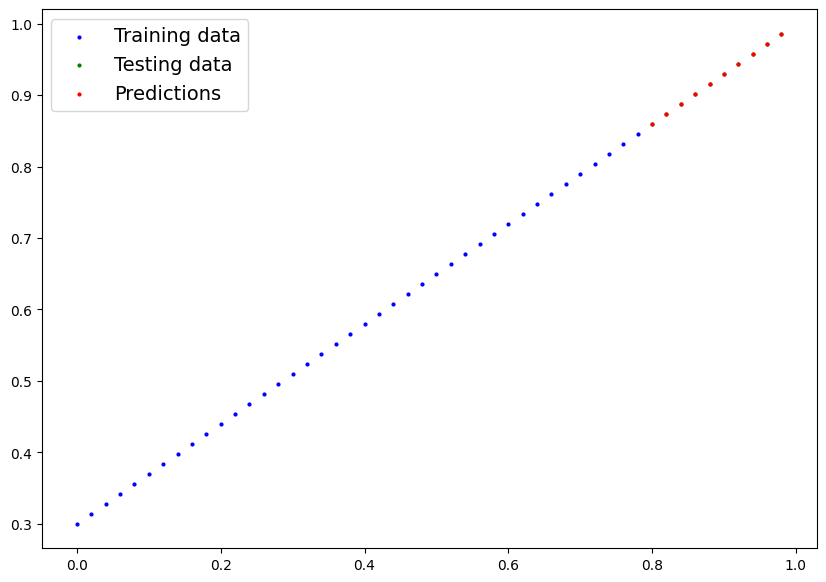

In [57]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

plot_predictions(predictions=y_preds.cpu())

In [58]:
MODEL_NAME = "pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/pytorch_workflow_model_1.pth


In [59]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# loaded_model_1.to(device)

<All keys matched successfully>

In [60]:
loaded_model_1.state_dict() == model_1.state_dict()

True

In [61]:
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])